In [59]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from fuzzy_layer import FuzzyLayer

In [60]:
writer = SummaryWriter(f'runs/mnist/fсvae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
significant_labels = 10 #количество размеченных классов, вся разметка от 10 и выше считается неразмеченным классом

In [61]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [62]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
len(train_data)

60000

In [63]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
)
len(test_data)

10000

In [64]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [65]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        input_dim (int): Размерность входных данных.
        hidden_dim (int): Размер внутренних слоев.
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [66]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        input_dim (int): Размерность входных данных.
        hidden_dim (int): Размер внутренних слоев.
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [67]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        input_dim (int): Размерность входных данных.
        hidden_dim (int): Размер внутренних слоев.
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim, labels_count):
        super(CVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)

        self.fuzzy = nn.Sequential(
             nn.Linear(latent_dim, latent_dim),
             FuzzyLayer.fromdimentions(latent_dim, labels_count, trainable=True)

        )
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        labels = self.fuzzy(mu)

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z = self.encoder(x)
        labels = self.fuzzy(mu)

        return mu, logvar, z, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [68]:
def compute_loss(x, recon_x, mu, logvar, z, target_labels, predicted_labels):
    
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
            
    weight = torch.where(target_labels >= significant_labels, 0.0, 1.0).to(z.device)
    meaningful = sum(weight, 0).to(z.device)
    ratio = weight.shape[0]/ (meaningful+1).to(z.device)
    filteredLabels = torch.where(target_labels >= significant_labels, 0, target_labels).to(z.device)
    oh = nn.functional.one_hot(filteredLabels, significant_labels).reshape(predicted_labels.shape).to(z.device)
    #print(f"oh {oh.shape}")
    #print(f"predicted_labels-oh {(torch.sum(torch.square(predicted_labels-oh), dim=-1)).shape}")
    #print(f"weight {weight.shape}")
    #print(f"ratio {ratio.shape}")
    loss_fuzzy = ratio * torch.mean(torch.mul(weight, torch.sum(torch.square(predicted_labels-oh), dim=-1)))

    loss = loss_recon + loss_kl + loss_fuzzy

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [69]:
model = CVAE(latent_dim=latent_dim, labels_count=significant_labels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,690,323


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=4, bias=True)
    )
    (softplus): Softplus(beta=1, threshold=20)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [70]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [71]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logcar, z, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z, target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Fuzzy/Train/Loss', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [72]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logcar, z, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z,  target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()
            pred_target = np.argmax(labels.cpu().numpy(), axis=1)
            target_labels =  target.cpu().numpy()
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f} Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Loss', loss_fuzzy.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [73]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 21.6819 (Recon: 19.8444, KL: 0.1792 Fuzzy: 1.6584) Grad: 13.8358
Step 100 (N samples: 25,600), Loss: 8.9208 (Recon: 7.3445, KL: 0.4741 Fuzzy: 1.1022) Grad: 8.9350
Step 200 (N samples: 51,200), Loss: 8.1615 (Recon: 6.6818, KL: 0.6478 Fuzzy: 0.8320) Grad: 8.1687


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.0990 (BCE: 6.6775, KLD: 0.6320 Fuzzy: 0.7895 Accuracy 0.2494)
Epoch 2/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 7.9698 (Recon: 6.5891, KL: 0.6289 Fuzzy: 0.7518) Grad: 7.1011
Step 400 (N samples: 102,400), Loss: 7.8289 (Recon: 6.3835, KL: 0.7156 Fuzzy: 0.7298) Grad: 4.8440


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.9738 (BCE: 6.3311, KLD: 0.8906 Fuzzy: 0.7522 Accuracy 0.3800)
Epoch 3/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 7.8542 (Recon: 6.4270, KL: 0.7064 Fuzzy: 0.7208) Grad: 4.9661
Step 600 (N samples: 153,600), Loss: 7.7189 (Recon: 6.2840, KL: 0.7540 Fuzzy: 0.6809) Grad: 3.7493
Step 700 (N samples: 179,200), Loss: 7.7469 (Recon: 6.3884, KL: 0.7008 Fuzzy: 0.6577) Grad: 6.3386


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.9388 (BCE: 6.2324, KLD: 0.9940 Fuzzy: 0.7124 Accuracy 0.4235)
Epoch 4/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 7.5034 (Recon: 6.1468, KL: 0.7866 Fuzzy: 0.5700) Grad: 3.2978
Step 900 (N samples: 230,400), Loss: 7.8254 (Recon: 6.3803, KL: 0.8249 Fuzzy: 0.6202) Grad: 4.5386


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5430 (BCE: 6.1981, KLD: 0.8650 Fuzzy: 0.4799 Accuracy 0.6785)
Epoch 5/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.5983 (Recon: 6.2098, KL: 0.9191 Fuzzy: 0.4695) Grad: 4.3797
Step 1,100 (N samples: 281,600), Loss: 7.4528 (Recon: 6.1436, KL: 0.8744 Fuzzy: 0.4348) Grad: 2.7570


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5094 (BCE: 6.2826, KLD: 0.8059 Fuzzy: 0.4210 Accuracy 0.7596)
Epoch 6/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 7.5563 (Recon: 6.3197, KL: 0.8389 Fuzzy: 0.3977) Grad: 3.0258
Step 1,300 (N samples: 332,800), Loss: 7.4850 (Recon: 6.2447, KL: 0.8748 Fuzzy: 0.3654) Grad: 3.1577
Step 1,400 (N samples: 358,400), Loss: 7.5529 (Recon: 6.2943, KL: 0.8948 Fuzzy: 0.3638) Grad: 5.3191


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4866 (BCE: 6.2190, KLD: 0.8730 Fuzzy: 0.3946 Accuracy 0.7846)
Epoch 7/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 7.2724 (Recon: 6.0159, KL: 0.8910 Fuzzy: 0.3654) Grad: 5.0345
Step 1,600 (N samples: 409,600), Loss: 7.3156 (Recon: 6.0188, KL: 0.8531 Fuzzy: 0.4436) Grad: 5.6866


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4063 (BCE: 6.1082, KLD: 0.9875 Fuzzy: 0.3106 Accuracy 0.8866)
Epoch 8/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 7.5822 (Recon: 6.3759, KL: 0.8622 Fuzzy: 0.3441) Grad: 4.0600
Step 1,800 (N samples: 460,800), Loss: 7.6506 (Recon: 6.4173, KL: 0.9265 Fuzzy: 0.3069) Grad: 3.5341


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3105 (BCE: 6.0606, KLD: 0.9986 Fuzzy: 0.2514 Accuracy 0.9054)
Epoch 9/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 7.2902 (Recon: 6.1215, KL: 0.9060 Fuzzy: 0.2626) Grad: 4.4751
Step 2,000 (N samples: 512,000), Loss: 7.3403 (Recon: 6.1216, KL: 0.9156 Fuzzy: 0.3031) Grad: 5.0308
Step 2,100 (N samples: 537,600), Loss: 7.3832 (Recon: 6.1947, KL: 0.9586 Fuzzy: 0.2299) Grad: 4.3071


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3134 (BCE: 6.0537, KLD: 0.9909 Fuzzy: 0.2688 Accuracy 0.9077)
Epoch 10/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 7.1950 (Recon: 5.9807, KL: 0.9775 Fuzzy: 0.2368) Grad: 3.2104
Step 2,300 (N samples: 588,800), Loss: 7.2951 (Recon: 6.1552, KL: 0.9118 Fuzzy: 0.2281) Grad: 4.2031


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2497 (BCE: 6.0587, KLD: 0.9623 Fuzzy: 0.2287 Accuracy 0.9206)
Epoch 11/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,400 (N samples: 614,400), Loss: 7.1574 (Recon: 6.0116, KL: 0.9481 Fuzzy: 0.1977) Grad: 3.0569
Step 2,500 (N samples: 640,000), Loss: 7.1958 (Recon: 6.0052, KL: 0.9482 Fuzzy: 0.2424) Grad: 3.8450


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2312 (BCE: 6.0572, KLD: 0.9795 Fuzzy: 0.1945 Accuracy 0.9320)
Epoch 12/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,600 (N samples: 665,600), Loss: 7.2079 (Recon: 6.0615, KL: 0.9666 Fuzzy: 0.1799) Grad: 3.1989
Step 2,700 (N samples: 691,200), Loss: 7.3925 (Recon: 6.2419, KL: 0.9604 Fuzzy: 0.1902) Grad: 3.1545
Step 2,800 (N samples: 716,800), Loss: 7.2026 (Recon: 6.0038, KL: 0.9794 Fuzzy: 0.2194) Grad: 4.0889


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2484 (BCE: 6.0226, KLD: 1.0172 Fuzzy: 0.2086 Accuracy 0.9360)
Epoch 13/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,900 (N samples: 742,400), Loss: 7.2144 (Recon: 6.0143, KL: 0.9614 Fuzzy: 0.2387) Grad: 5.2227
Step 3,000 (N samples: 768,000), Loss: 7.1571 (Recon: 5.9330, KL: 0.9650 Fuzzy: 0.2591) Grad: 5.1608


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2284 (BCE: 6.0791, KLD: 0.9551 Fuzzy: 0.1941 Accuracy 0.9376)
Epoch 14/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,100 (N samples: 793,600), Loss: 7.1797 (Recon: 6.0232, KL: 0.9604 Fuzzy: 0.1961) Grad: 3.5646
Step 3,200 (N samples: 819,200), Loss: 7.3077 (Recon: 6.0878, KL: 1.0002 Fuzzy: 0.2197) Grad: 3.8638


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1513 (BCE: 6.0007, KLD: 0.9873 Fuzzy: 0.1634 Accuracy 0.9422)
Epoch 15/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,300 (N samples: 844,800), Loss: 7.3132 (Recon: 6.1211, KL: 1.0083 Fuzzy: 0.1838) Grad: 2.7017
Step 3,400 (N samples: 870,400), Loss: 7.1305 (Recon: 5.9810, KL: 0.9685 Fuzzy: 0.1809) Grad: 2.3472
Step 3,500 (N samples: 896,000), Loss: 7.3052 (Recon: 6.0954, KL: 0.9898 Fuzzy: 0.2201) Grad: 4.9709


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2091 (BCE: 6.0249, KLD: 1.0021 Fuzzy: 0.1820 Accuracy 0.9472)
Epoch 16/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,600 (N samples: 921,600), Loss: 7.0336 (Recon: 5.9148, KL: 0.9696 Fuzzy: 0.1492) Grad: 3.8439
Step 3,700 (N samples: 947,200), Loss: 7.2479 (Recon: 6.0322, KL: 0.9991 Fuzzy: 0.2166) Grad: 4.7131


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1593 (BCE: 6.0080, KLD: 0.9890 Fuzzy: 0.1623 Accuracy 0.9497)
Epoch 17/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,800 (N samples: 972,800), Loss: 7.4958 (Recon: 6.2788, KL: 0.9649 Fuzzy: 0.2521) Grad: 4.8298
Step 3,900 (N samples: 998,400), Loss: 7.1422 (Recon: 5.9338, KL: 1.0564 Fuzzy: 0.1521) Grad: 3.0232


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1480 (BCE: 5.9872, KLD: 0.9973 Fuzzy: 0.1635 Accuracy 0.9498)
Epoch 18/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,000 (N samples: 1,024,000), Loss: 7.3243 (Recon: 6.1077, KL: 1.0238 Fuzzy: 0.1929) Grad: 4.3218
Step 4,100 (N samples: 1,049,600), Loss: 6.9967 (Recon: 5.8458, KL: 1.0157 Fuzzy: 0.1352) Grad: 2.5339
Step 4,200 (N samples: 1,075,200), Loss: 7.2055 (Recon: 6.0793, KL: 0.9800 Fuzzy: 0.1462) Grad: 3.8426


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1761 (BCE: 6.0347, KLD: 0.9784 Fuzzy: 0.1630 Accuracy 0.9479)
Epoch 19/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,300 (N samples: 1,100,800), Loss: 7.1642 (Recon: 5.9257, KL: 1.0300 Fuzzy: 0.2084) Grad: 5.0289
Step 4,400 (N samples: 1,126,400), Loss: 7.1747 (Recon: 5.9917, KL: 1.0110 Fuzzy: 0.1720) Grad: 2.9355


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1934 (BCE: 6.0002, KLD: 1.0271 Fuzzy: 0.1662 Accuracy 0.9504)
Epoch 20/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,500 (N samples: 1,152,000), Loss: 7.4725 (Recon: 6.1649, KL: 1.0204 Fuzzy: 0.2872) Grad: 5.4458
Step 4,600 (N samples: 1,177,600), Loss: 7.1810 (Recon: 5.9743, KL: 1.0402 Fuzzy: 0.1665) Grad: 2.5394


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1649 (BCE: 6.0108, KLD: 0.9956 Fuzzy: 0.1585 Accuracy 0.9457)
Epoch 21/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,700 (N samples: 1,203,200), Loss: 7.2950 (Recon: 6.1142, KL: 0.9829 Fuzzy: 0.1979) Grad: 2.7249
Step 4,800 (N samples: 1,228,800), Loss: 7.1851 (Recon: 5.9685, KL: 1.0613 Fuzzy: 0.1553) Grad: 2.3477
Step 4,900 (N samples: 1,254,400), Loss: 7.0496 (Recon: 5.8400, KL: 1.0743 Fuzzy: 0.1353) Grad: 2.8414


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1248 (BCE: 5.9409, KLD: 1.0336 Fuzzy: 0.1502 Accuracy 0.9538)
Epoch 22/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,000 (N samples: 1,280,000), Loss: 7.2550 (Recon: 6.0759, KL: 1.0183 Fuzzy: 0.1608) Grad: 2.3784
Step 5,100 (N samples: 1,305,600), Loss: 7.1078 (Recon: 5.9187, KL: 1.0307 Fuzzy: 0.1584) Grad: 2.8139


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1266 (BCE: 5.9308, KLD: 1.0445 Fuzzy: 0.1513 Accuracy 0.9537)
Epoch 23/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,200 (N samples: 1,331,200), Loss: 7.1861 (Recon: 5.9916, KL: 1.0433 Fuzzy: 0.1511) Grad: 2.6189
Step 5,300 (N samples: 1,356,800), Loss: 7.0971 (Recon: 5.8912, KL: 1.0530 Fuzzy: 0.1528) Grad: 3.9797
Step 5,400 (N samples: 1,382,400), Loss: 7.0857 (Recon: 5.8807, KL: 1.0556 Fuzzy: 0.1494) Grad: 3.1009


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1255 (BCE: 5.9455, KLD: 1.0323 Fuzzy: 0.1477 Accuracy 0.9551)
Epoch 24/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,500 (N samples: 1,408,000), Loss: 7.2846 (Recon: 6.0039, KL: 1.0814 Fuzzy: 0.1993) Grad: 4.9709
Step 5,600 (N samples: 1,433,600), Loss: 7.2202 (Recon: 5.9924, KL: 1.0773 Fuzzy: 0.1506) Grad: 2.9769


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1254 (BCE: 5.9403, KLD: 1.0615 Fuzzy: 0.1236 Accuracy 0.9618)
Epoch 25/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,700 (N samples: 1,459,200), Loss: 7.1188 (Recon: 5.8513, KL: 1.0879 Fuzzy: 0.1796) Grad: 4.6845
Step 5,800 (N samples: 1,484,800), Loss: 7.2698 (Recon: 6.0703, KL: 1.0305 Fuzzy: 0.1691) Grad: 3.4233


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1305 (BCE: 5.9118, KLD: 1.0843 Fuzzy: 0.1345 Accuracy 0.9557)
Epoch 26/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,900 (N samples: 1,510,400), Loss: 7.0138 (Recon: 5.8334, KL: 1.0618 Fuzzy: 0.1185) Grad: 2.2035
Step 6,000 (N samples: 1,536,000), Loss: 7.1835 (Recon: 6.0097, KL: 1.0530 Fuzzy: 0.1207) Grad: 2.8374
Step 6,100 (N samples: 1,561,600), Loss: 7.1023 (Recon: 5.8822, KL: 1.0380 Fuzzy: 0.1820) Grad: 4.0041


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1272 (BCE: 5.9687, KLD: 1.0145 Fuzzy: 0.1440 Accuracy 0.9567)
Epoch 27/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,200 (N samples: 1,587,200), Loss: 7.0769 (Recon: 5.9224, KL: 1.0166 Fuzzy: 0.1379) Grad: 3.0282
Step 6,300 (N samples: 1,612,800), Loss: 6.9666 (Recon: 5.7261, KL: 1.1062 Fuzzy: 0.1343) Grad: 3.2012


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0809 (BCE: 5.8479, KLD: 1.1100 Fuzzy: 0.1229 Accuracy 0.9616)
Epoch 28/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,400 (N samples: 1,638,400), Loss: 7.1325 (Recon: 5.9573, KL: 1.0557 Fuzzy: 0.1195) Grad: 1.6945
Step 6,500 (N samples: 1,664,000), Loss: 6.9981 (Recon: 5.8103, KL: 1.0726 Fuzzy: 0.1152) Grad: 2.0750


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1077 (BCE: 5.8875, KLD: 1.0778 Fuzzy: 0.1423 Accuracy 0.9599)
Epoch 29/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,600 (N samples: 1,689,600), Loss: 7.1049 (Recon: 5.8731, KL: 1.1076 Fuzzy: 0.1242) Grad: 3.4616
Step 6,700 (N samples: 1,715,200), Loss: 7.1387 (Recon: 5.9123, KL: 1.0927 Fuzzy: 0.1337) Grad: 3.7461
Step 6,800 (N samples: 1,740,800), Loss: 7.3809 (Recon: 6.1792, KL: 1.0424 Fuzzy: 0.1592) Grad: 4.4302


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1526 (BCE: 5.9535, KLD: 1.0368 Fuzzy: 0.1623 Accuracy 0.9538)
Epoch 30/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,900 (N samples: 1,766,400), Loss: 7.1599 (Recon: 5.8919, KL: 1.0785 Fuzzy: 0.1895) Grad: 4.9751
Step 7,000 (N samples: 1,792,000), Loss: 7.2693 (Recon: 6.0202, KL: 1.0771 Fuzzy: 0.1720) Grad: 4.2411


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0983 (BCE: 5.8762, KLD: 1.0990 Fuzzy: 0.1231 Accuracy 0.9603)
Epoch 31/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,100 (N samples: 1,817,600), Loss: 7.1724 (Recon: 5.9609, KL: 1.0978 Fuzzy: 0.1138) Grad: 1.8272
Step 7,200 (N samples: 1,843,200), Loss: 7.1107 (Recon: 5.8690, KL: 1.0870 Fuzzy: 0.1548) Grad: 3.0031


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0870 (BCE: 5.8621, KLD: 1.1039 Fuzzy: 0.1210 Accuracy 0.9612)
Epoch 32/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,300 (N samples: 1,868,800), Loss: 7.1428 (Recon: 5.9540, KL: 1.0624 Fuzzy: 0.1264) Grad: 1.4216
Step 7,400 (N samples: 1,894,400), Loss: 7.2773 (Recon: 6.0772, KL: 1.0570 Fuzzy: 0.1431) Grad: 1.7608
Step 7,500 (N samples: 1,920,000), Loss: 7.1761 (Recon: 5.9828, KL: 1.0869 Fuzzy: 0.1063) Grad: 2.4796


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0938 (BCE: 5.8730, KLD: 1.0941 Fuzzy: 0.1267 Accuracy 0.9590)
Epoch 33/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,600 (N samples: 1,945,600), Loss: 7.0844 (Recon: 5.8605, KL: 1.0942 Fuzzy: 0.1297) Grad: 2.5502
Step 7,700 (N samples: 1,971,200), Loss: 7.0889 (Recon: 5.8668, KL: 1.0820 Fuzzy: 0.1400) Grad: 1.9406


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0620 (BCE: 5.8461, KLD: 1.1003 Fuzzy: 0.1156 Accuracy 0.9601)
Epoch 34/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,800 (N samples: 1,996,800), Loss: 6.9584 (Recon: 5.6621, KL: 1.1329 Fuzzy: 0.1634) Grad: 3.8731
Step 7,900 (N samples: 2,022,400), Loss: 7.0799 (Recon: 5.8442, KL: 1.1010 Fuzzy: 0.1348) Grad: 3.0458


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0906 (BCE: 5.8848, KLD: 1.0804 Fuzzy: 0.1254 Accuracy 0.9594)
Epoch 35/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,000 (N samples: 2,048,000), Loss: 7.1875 (Recon: 5.9778, KL: 1.0781 Fuzzy: 0.1315) Grad: 2.7155
Step 8,100 (N samples: 2,073,600), Loss: 6.9448 (Recon: 5.7129, KL: 1.0827 Fuzzy: 0.1493) Grad: 2.1525
Step 8,200 (N samples: 2,099,200), Loss: 7.0821 (Recon: 5.8045, KL: 1.1206 Fuzzy: 0.1571) Grad: 2.9930


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0670 (BCE: 5.8555, KLD: 1.0783 Fuzzy: 0.1333 Accuracy 0.9617)
Epoch 36/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,300 (N samples: 2,124,800), Loss: 6.9785 (Recon: 5.7265, KL: 1.1389 Fuzzy: 0.1130) Grad: 2.1547
Step 8,400 (N samples: 2,150,400), Loss: 7.2878 (Recon: 6.0223, KL: 1.1021 Fuzzy: 0.1634) Grad: 4.2722


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0595 (BCE: 5.8277, KLD: 1.1201 Fuzzy: 0.1118 Accuracy 0.9629)
Epoch 37/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,500 (N samples: 2,176,000), Loss: 6.9177 (Recon: 5.7050, KL: 1.0874 Fuzzy: 0.1254) Grad: 2.2712
Step 8,600 (N samples: 2,201,600), Loss: 7.0218 (Recon: 5.8259, KL: 1.0912 Fuzzy: 0.1047) Grad: 2.5596


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0720 (BCE: 5.8595, KLD: 1.1012 Fuzzy: 0.1113 Accuracy 0.9636)
Epoch 38/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,700 (N samples: 2,227,200), Loss: 7.2060 (Recon: 6.0257, KL: 1.0559 Fuzzy: 0.1244) Grad: 3.8948
Step 8,800 (N samples: 2,252,800), Loss: 7.1255 (Recon: 5.8646, KL: 1.1010 Fuzzy: 0.1598) Grad: 2.1372
Step 8,900 (N samples: 2,278,400), Loss: 7.1037 (Recon: 5.8664, KL: 1.1175 Fuzzy: 0.1199) Grad: 2.4068


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0961 (BCE: 5.8741, KLD: 1.1028 Fuzzy: 0.1192 Accuracy 0.9636)
Epoch 39/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,000 (N samples: 2,304,000), Loss: 7.1927 (Recon: 5.9409, KL: 1.1419 Fuzzy: 0.1099) Grad: 3.2562
Step 9,100 (N samples: 2,329,600), Loss: 6.9685 (Recon: 5.7679, KL: 1.1063 Fuzzy: 0.0943) Grad: 2.5484


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0724 (BCE: 5.8351, KLD: 1.1132 Fuzzy: 0.1242 Accuracy 0.9630)
Epoch 40/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,200 (N samples: 2,355,200), Loss: 7.3810 (Recon: 6.1357, KL: 1.0663 Fuzzy: 0.1790) Grad: 5.6337
Step 9,300 (N samples: 2,380,800), Loss: 7.2610 (Recon: 6.0452, KL: 1.1012 Fuzzy: 0.1146) Grad: 3.6161


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0540 (BCE: 5.8191, KLD: 1.1235 Fuzzy: 0.1114 Accuracy 0.9653)
Epoch 41/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,400 (N samples: 2,406,400), Loss: 6.9093 (Recon: 5.6545, KL: 1.1301 Fuzzy: 0.1247) Grad: 2.8483
Step 9,500 (N samples: 2,432,000), Loss: 7.1414 (Recon: 5.9184, KL: 1.0858 Fuzzy: 0.1372) Grad: 4.1049
Step 9,600 (N samples: 2,457,600), Loss: 7.0269 (Recon: 5.7706, KL: 1.1275 Fuzzy: 0.1288) Grad: 4.6386


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0714 (BCE: 5.8320, KLD: 1.1189 Fuzzy: 0.1205 Accuracy 0.9653)
Epoch 42/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,700 (N samples: 2,483,200), Loss: 7.4983 (Recon: 6.2126, KL: 1.1023 Fuzzy: 0.1834) Grad: 4.9723
Step 9,800 (N samples: 2,508,800), Loss: 7.2505 (Recon: 5.9708, KL: 1.1105 Fuzzy: 0.1692) Grad: 3.9662


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0507 (BCE: 5.8080, KLD: 1.1185 Fuzzy: 0.1243 Accuracy 0.9638)
Epoch 43/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,900 (N samples: 2,534,400), Loss: 6.9726 (Recon: 5.7347, KL: 1.1103 Fuzzy: 0.1276) Grad: 4.0125
Step 10,000 (N samples: 2,560,000), Loss: 7.3063 (Recon: 6.0886, KL: 1.0708 Fuzzy: 0.1469) Grad: 2.6731
Step 10,100 (N samples: 2,585,600), Loss: 6.9970 (Recon: 5.7323, KL: 1.1262 Fuzzy: 0.1385) Grad: 3.9777


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0399 (BCE: 5.8179, KLD: 1.1161 Fuzzy: 0.1060 Accuracy 0.9683)
Epoch 44/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,200 (N samples: 2,611,200), Loss: 7.1160 (Recon: 5.8087, KL: 1.1503 Fuzzy: 0.1569) Grad: 4.5156
Step 10,300 (N samples: 2,636,800), Loss: 6.8782 (Recon: 5.6222, KL: 1.1433 Fuzzy: 0.1127) Grad: 2.6174


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0674 (BCE: 5.8326, KLD: 1.1251 Fuzzy: 0.1097 Accuracy 0.9658)
Epoch 45/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,400 (N samples: 2,662,400), Loss: 7.1274 (Recon: 5.8612, KL: 1.1040 Fuzzy: 0.1621) Grad: 4.3854
Step 10,500 (N samples: 2,688,000), Loss: 7.2994 (Recon: 6.0524, KL: 1.1294 Fuzzy: 0.1177) Grad: 2.6740


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0924 (BCE: 5.8696, KLD: 1.0952 Fuzzy: 0.1276 Accuracy 0.9626)
Epoch 46/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,600 (N samples: 2,713,600), Loss: 7.1693 (Recon: 5.9194, KL: 1.1218 Fuzzy: 0.1281) Grad: 2.3655
Step 10,700 (N samples: 2,739,200), Loss: 7.1489 (Recon: 5.9173, KL: 1.1065 Fuzzy: 0.1251) Grad: 3.6518
Step 10,800 (N samples: 2,764,800), Loss: 7.1719 (Recon: 5.9282, KL: 1.1233 Fuzzy: 0.1203) Grad: 2.2231


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0636 (BCE: 5.8218, KLD: 1.1254 Fuzzy: 0.1164 Accuracy 0.9658)
Epoch 47/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,900 (N samples: 2,790,400), Loss: 7.3031 (Recon: 6.0454, KL: 1.1169 Fuzzy: 0.1408) Grad: 3.6143
Step 11,000 (N samples: 2,816,000), Loss: 7.1496 (Recon: 5.8367, KL: 1.1618 Fuzzy: 0.1510) Grad: 4.1794


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0608 (BCE: 5.8427, KLD: 1.0950 Fuzzy: 0.1231 Accuracy 0.9619)
Epoch 48/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,100 (N samples: 2,841,600), Loss: 7.0357 (Recon: 5.7873, KL: 1.1309 Fuzzy: 0.1175) Grad: 2.4516
Step 11,200 (N samples: 2,867,200), Loss: 7.0125 (Recon: 5.7866, KL: 1.1285 Fuzzy: 0.0974) Grad: 1.8223


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0507 (BCE: 5.7941, KLD: 1.1414 Fuzzy: 0.1153 Accuracy 0.9681)
Epoch 49/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,300 (N samples: 2,892,800), Loss: 7.1792 (Recon: 5.9162, KL: 1.1391 Fuzzy: 0.1239) Grad: 3.8893
Step 11,400 (N samples: 2,918,400), Loss: 7.1182 (Recon: 5.9051, KL: 1.1036 Fuzzy: 0.1094) Grad: 1.4024
Step 11,500 (N samples: 2,944,000), Loss: 7.1739 (Recon: 5.9573, KL: 1.1246 Fuzzy: 0.0919) Grad: 2.6477


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0538 (BCE: 5.8247, KLD: 1.1109 Fuzzy: 0.1181 Accuracy 0.9652)
Epoch 50/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,600 (N samples: 2,969,600), Loss: 7.0214 (Recon: 5.7653, KL: 1.1456 Fuzzy: 0.1106) Grad: 2.7769
Step 11,700 (N samples: 2,995,200), Loss: 6.9523 (Recon: 5.6803, KL: 1.1400 Fuzzy: 0.1319) Grad: 2.5223


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0508 (BCE: 5.8183, KLD: 1.1229 Fuzzy: 0.1097 Accuracy 0.9664)


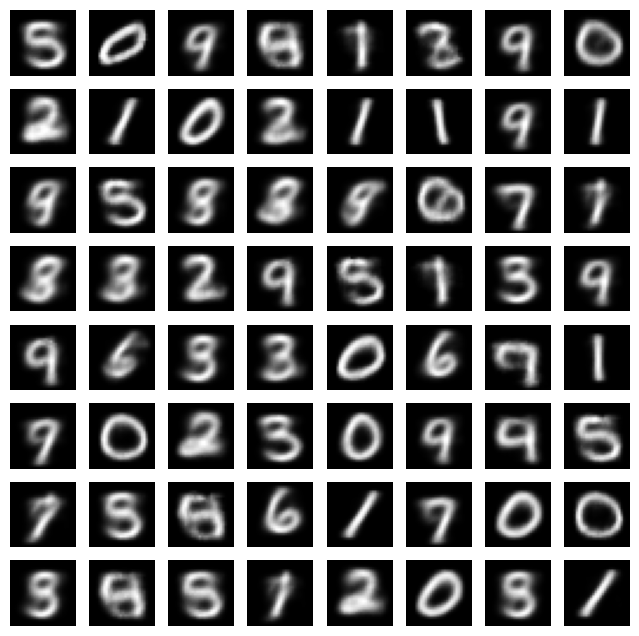

In [74]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)
# samples = torch.sigmoid(samples)

# print first sample
# print(samples[0])

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('vae_mnist.webp')

In [75]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
pred_y_all = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, labels = model.forward(data)
        z_all.append(mu.cpu().numpy())
        y_all.append(target.numpy())
        pred_y_all.append(np.argmax(labels.cpu().numpy(), axis=1))

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [76]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
pred_y_all= np.concatenate(pred_y_all, axis=0)

In [77]:
np.sum(y_all==pred_y_all)/len(y_all)

0.9656

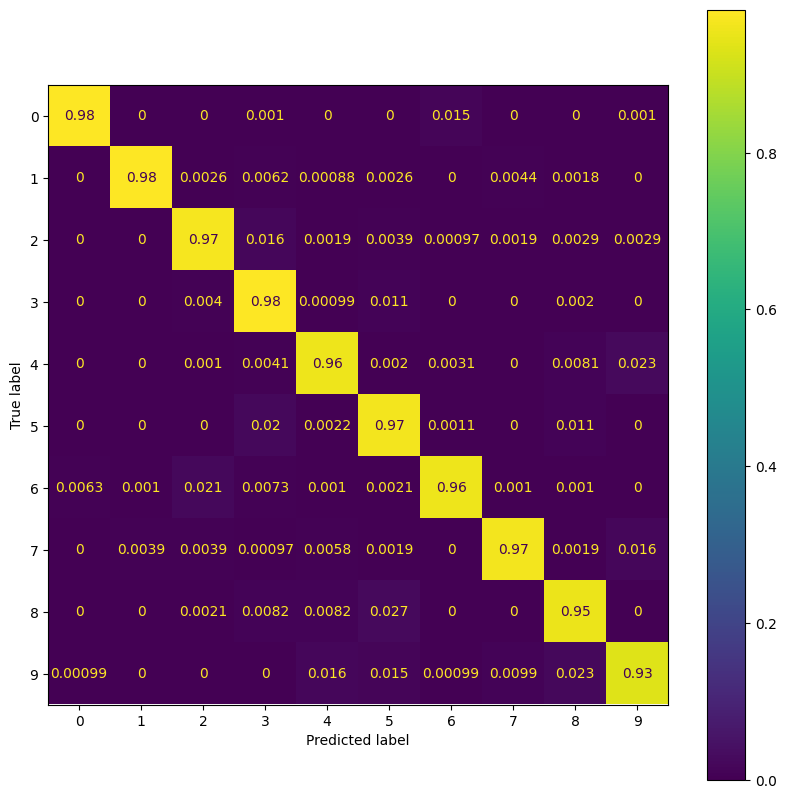

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_all, pred_y_all, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)

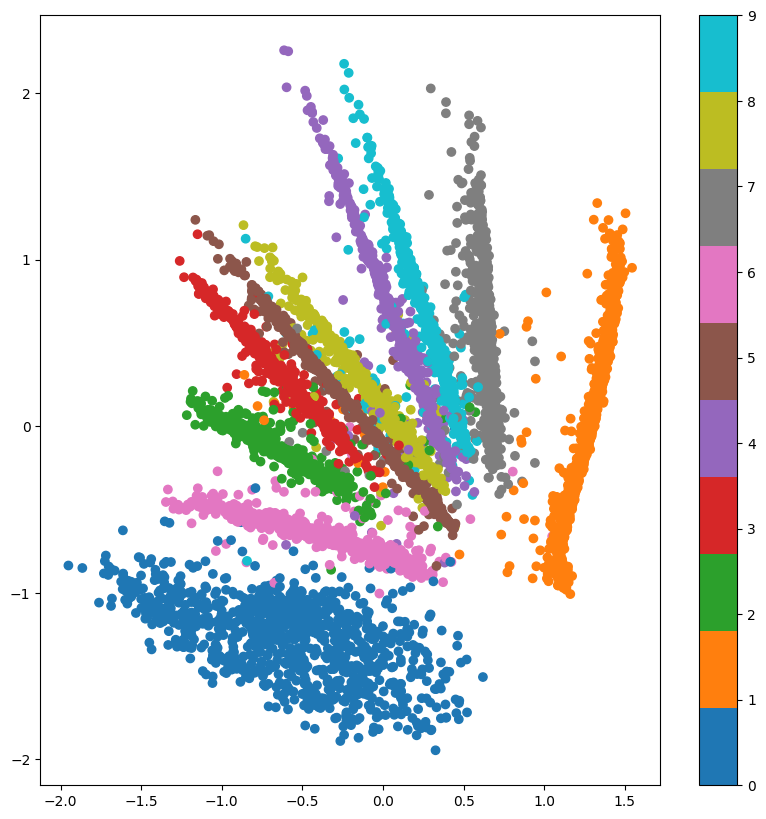

In [79]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_origin_labels.webp')

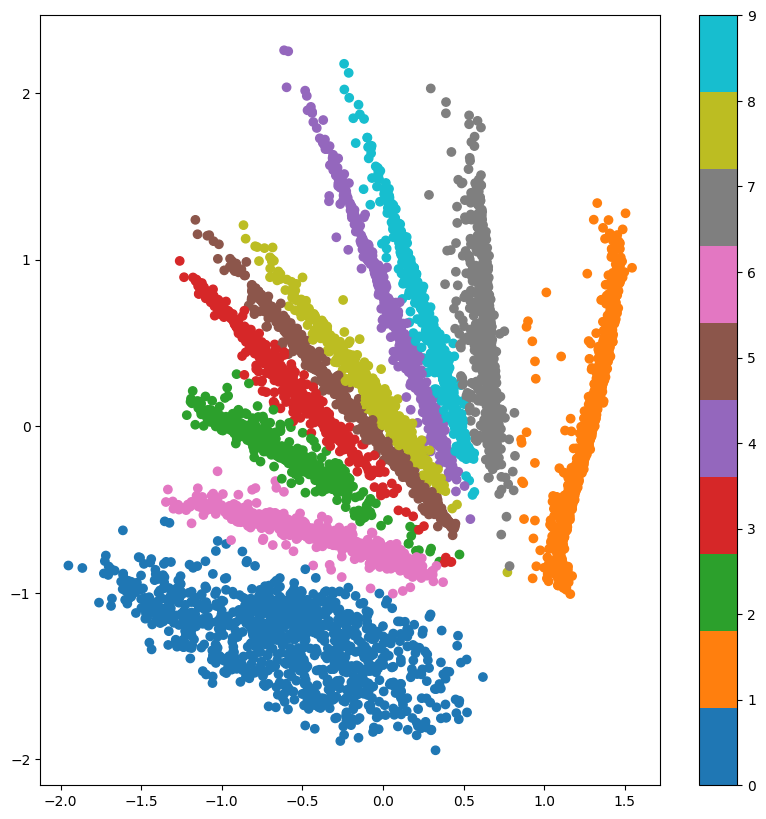

In [80]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_fuzzy_pred_labels.webp')

In [81]:
pred_y_all

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

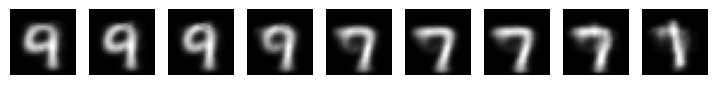

In [82]:
n = 9
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 1.2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('vae_mnist_interp.webp')